In [55]:
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [56]:
INPUT_NAME = 'connectivities_classifier-SVM_measure-accuracy_shap-enabled_agg-network_top-10_cv-100x4fold'

RESULTS = xr.open_dataset(f'models/{INPUT_NAME}.nc5', engine='scipy').load()
TOP_MODEL_NAMES = [name for name in RESULTS['grid_model_name'].values[:3]]
# top_model_scores = scores.query('label in @top_model_names').sort_values('mean_test_score')
MODEL_COLORS = ['#1BA1E2', '#6A00FF', '#D80073', 'orange', 'black', 'red']
pallete = sns.color_palette(MODEL_COLORS)


RESULTS

<xarray.Dataset>
Dimensions:                                                 (shap_dim: 800,
                                                             difumo64_networks_feature: 136,
                                                             gordon2014_networks_feature: 78,
                                                             dosenbach2010_networks_feature: 21,
                                                             permutation_importance_num: 500,
                                                             subject: 32,
                                                             grid_model_name: 15,
                                                             y_classes: 2)
Coordinates:
  * difumo64_networks_feature                               (difumo64_networks_feature) object ...
  * gordon2014_networks_feature                             (gordon2014_networks_feature) object ...
  * dosenbach2010_networks_feature                          (dosenbach2010_networks_feature) object ...
  * grid_model_name                                         (grid_model_name) object ...
  * y_classes                                               (y_classes) object ...
Dimensions without coordinates: shap_dim, permutation_importance_num, subject
Data variables: (12/166)
    difumo64_networks_precision shap                        (shap_dim, difumo64_networks_feature) float64 ...
    difumo64_networks_precision shap data                   (shap_dim, difumo64_networks_feature) float64 ...
    difumo64_networks_partial-correlation shap              (shap_dim, difumo64_networks_feature) float64 ...
    difumo64_networks_partial-correlation shap data         (shap_dim, difumo64_networks_feature) float64 ...
    gordon2014_networks_tangent shap                        (shap_dim, gordon2014_networks_feature) float64 ...
    gordon2014_networks_tangent shap data                   (shap_dim, gordon2014_networks_feature) float64 ...
    ...                                                      ...
    std_test_score                                          (grid_model_name) float64 ...
    rank_test_score                                         (grid_model_name) int32 ...
    scoring                                                 object 'accuracy'
    cv_test_size                                            int32 8
    cv_n_splits                                             int32 100
    n_subjects                                              int32 32

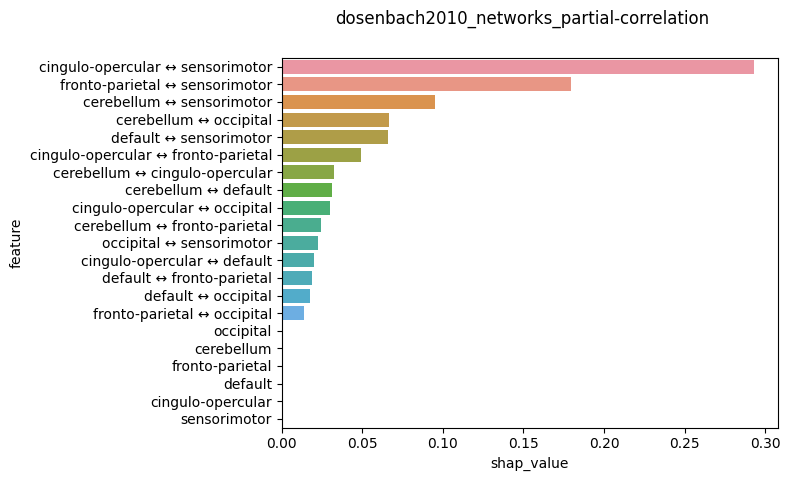

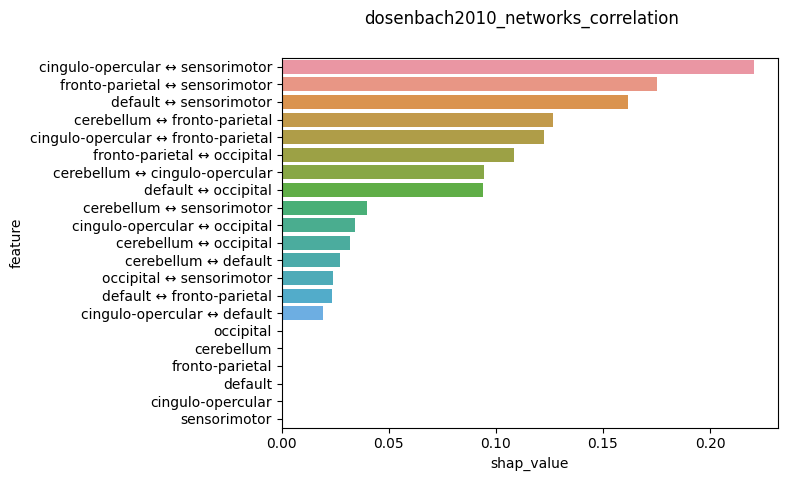

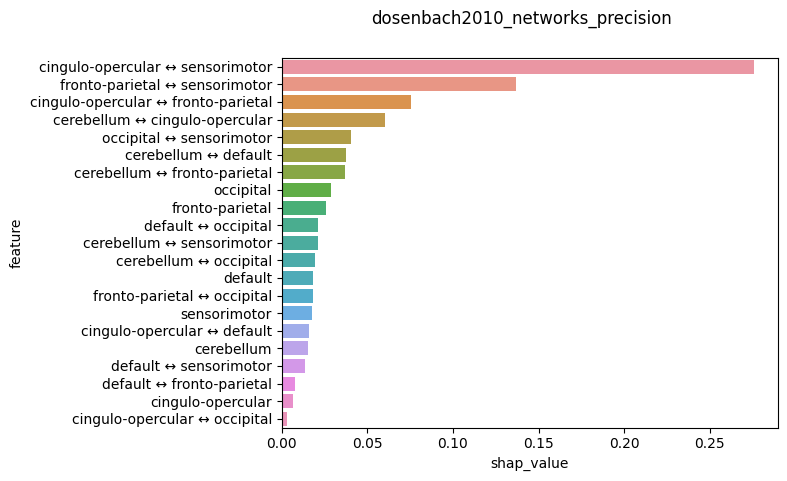

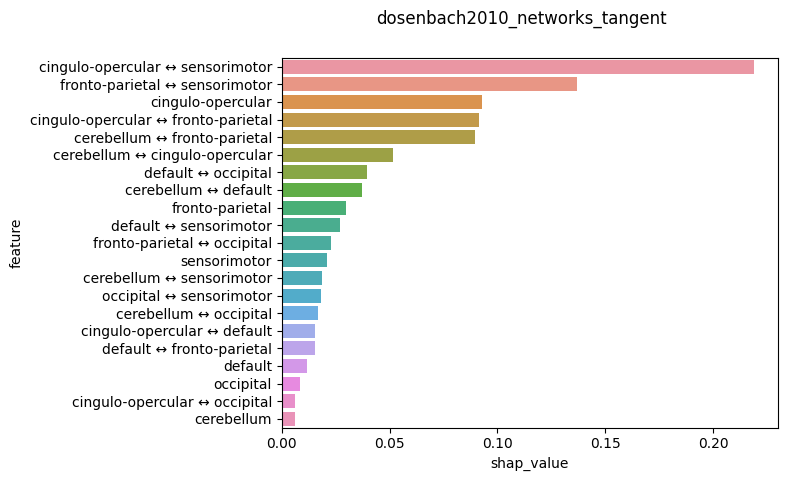

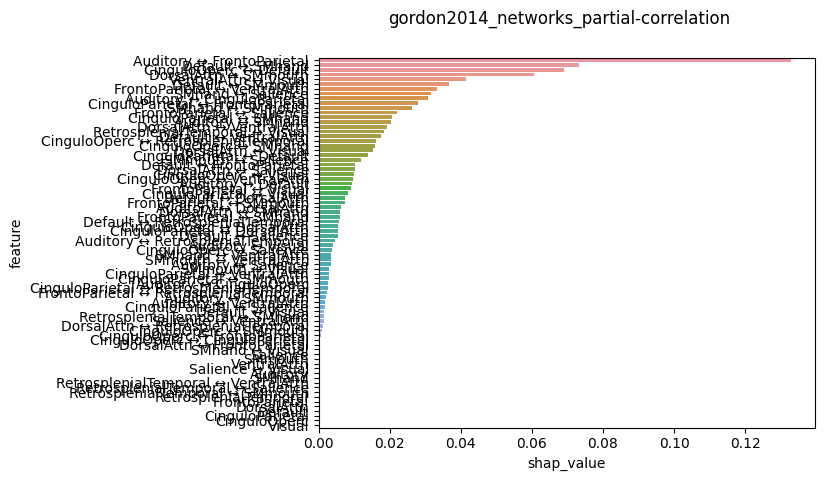

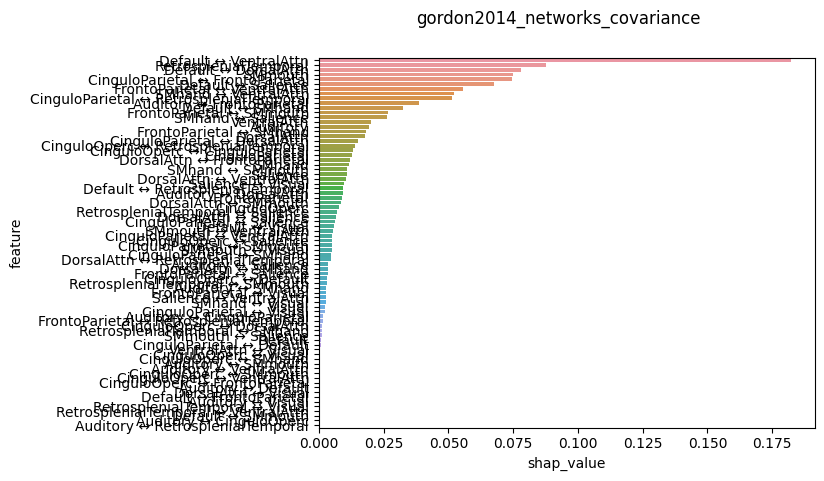

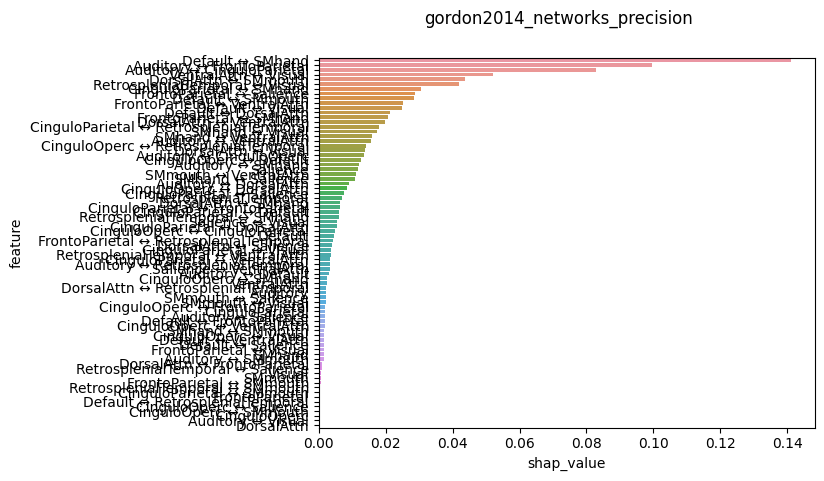

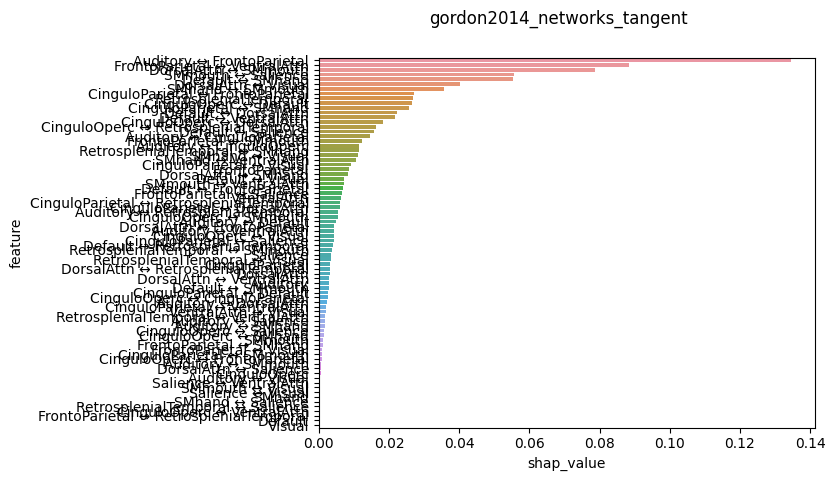

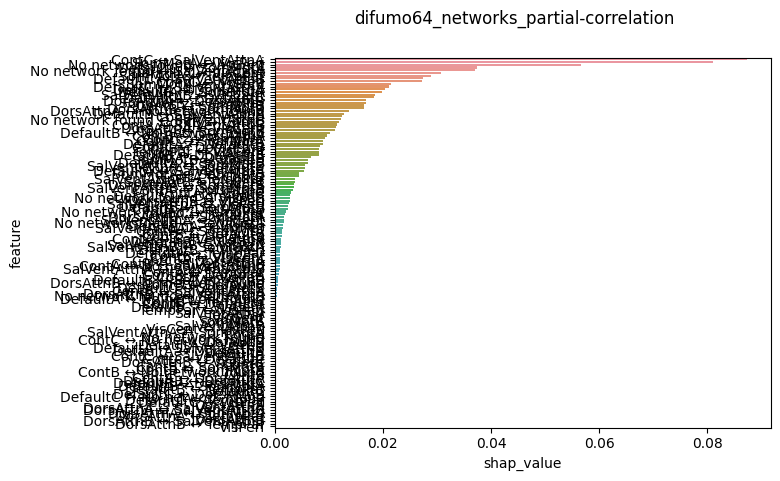

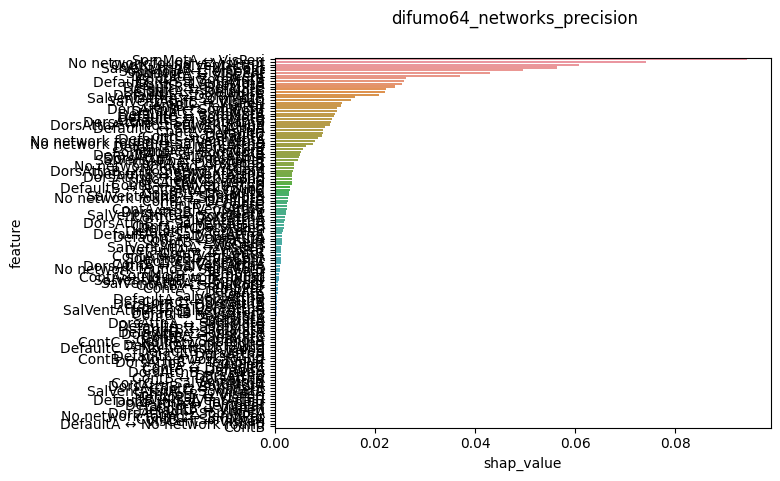

In [58]:
for model_name in RESULTS['grid_model_name'].values:
    shap_key = f'{model_name} shap'
    if shap_key in RESULTS.keys():
        shap_res = RESULTS[shap_key].to_dataframe().reset_index()
        shap_res.columns = ['shap_dim', 'feature', 'shap_value']
        shap_res['shap_value'] = shap_res['shap_value'].abs()
        shap_res = shap_res.groupby('feature').mean().sort_values('shap_value', ascending=False).reset_index()
        sns.barplot(data=shap_res, y='feature', x='shap_value', orient='h', label=model_name)
        plt.suptitle(model_name)
        plt.show()